In [1]:
%matplotlib notebook
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [246]:
def generate_data(size=1000,size_tr=900, num_digits=2):
    np.random_seed=1
    chars = '0123456789abcdef+ ' 
    maxlen = num_digits * 2 + 1
    char2idx = {c: i for i, c in enumerate(chars)} 
    idx2char = {i: c for i, c in enumerate(chars)}
    X = np.zeros((size, maxlen, len(chars)))
    y = np.zeros((size, num_digits + 1, len(chars)))
    n1 = np.random.randint(0, 16**(num_digits)-1, size)
    n2 = np.random.randint(0, 16**(num_digits)-1, size) 
    res = n1 + n2
    for i in range(size):
        inp = '%x+%x' % (n1[i], n2[i])
        inp += (maxlen - len(inp)) * ' '  
        out = '%x' % res[i]
        out += (num_digits + 1 - len(out)) * ' '
    for j, c in enumerate(inp[::-1]):  
        X[i, j, char2idx[c]] = 1
    for j, c in enumerate(out):
        y[i, j, char2idx[c]] = 1


    return X,y
    
    

In [247]:
def generate_data2(size=128, num_digits=2):
    np.random_seed=2
    chars = '0123456789abcdef+ '
    maxlen = num_digits * 2 + 1
    char2idx = {c: i for i, c in enumerate(chars)} 
    idx2char = {i: c for i, c in enumerate(chars)}
    X = np.zeros((size, maxlen, len(chars)))
    y = np.zeros((size, num_digits + 1, len(chars)))
    n1 = np.random.randint(0, 16**(num_digits)-1, size)
    n2 = np.random.randint(0, 16**(num_digits)-1, size) 
    res = n1 + n2
    for i in range(size):
        inp = '%x+%x' % (n1[i], n2[i])
        inp += (maxlen - len(inp)) * ' ' 
        out = '%x' % res[i]
        out += (num_digits + 1 - len(out)) * ' '
    for j, c in enumerate(inp[::-1]):  
        X[i, j, char2idx[c]] = 1
    for j, c in enumerate(out):
        y[i, j, char2idx[c]] = 1


    return X,y
    

In [261]:
from tensorflow.contrib import rnn
def network(rs,hidden=1,lr=0.00001,maxlen=5,epochs=10000):
    chars = '0123456789abcdef+ ' 
    tf.reset_default_graph()
    X=tf.placeholder(tf.float32,[None,maxlen,len(chars)])
    Y=tf.placeholder(tf.int32,[None, num_digits + 1, len(chars)])
    x=tf.unstack(X,maxlen,1)
    tf.set_random_seed(rs)
    basic_cell=tf.contrib.rnn.BasicRNNCell(num_units=hidden) # here the first set of weights and biases is defined
    rnn_output, states=rnn.static_rnn(basic_cell,x,dtype=tf.float32)
    with tf.variable_scope('foo'):
        cell2 = tf.contrib.rnn.BasicRNNCell(hidden)
        rnn_output2, states = tf.contrib.rnn.static_rnn(cell2, [rnn_output[-1]] * (num_digits + 1), dtype=tf.float32)

    
    logits = tf.contrib.layers.fully_connected(
     tf.stack(rnn_output2[-(num_digits+1):], axis=1),
     len(chars), activation_fn=None)

    loss = tf.losses.softmax_cross_entropy(Y, logits)
    predict=tf.nn.softmax(logits)
    correct_pred = tf.equal(tf.argmax(predict, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    optimizer=tf.train.AdamOptimizer(learning_rate=lr)
    training_op=optimizer.minimize(loss)
    init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True

    sess = tf.InteractiveSession(config=config)
    sess.run(init_op)
    lvals = []
    fig,ax = plt.subplots(1,1)
    for i in range(epochs): 
        x_batches, y_batches=generate_data()
        l, _ = sess.run([loss, training_op], feed_dict={
            X: x_batches,
            Y: y_batches
            })
        if i % 100 == 0:
            lvals.append(l)
            ax.clear()
            ax.plot(lvals)
            fig.canvas.draw()
    a=accuracy.eval(feed_dict={
              X: x_batches,
              Y: y_batches})
    print(a)
    x_test,y_test=generate_data2()
    a_test=accuracy.eval(feed_dict={X:x_test,Y:y_test})
    print(a_test)
    return a, a_test



<IPython.core.display.Javascript object>


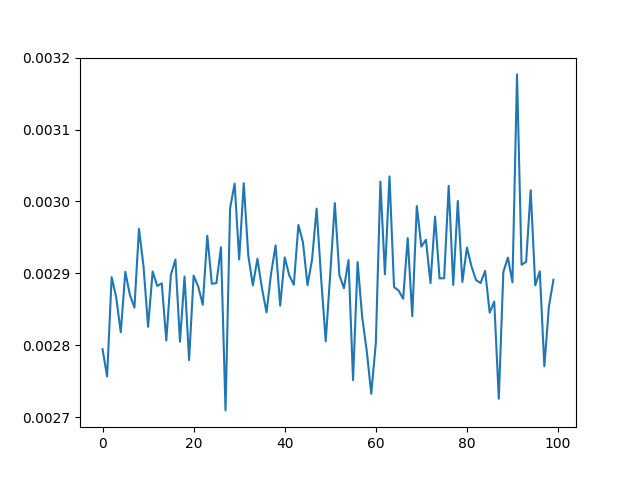

0.610889
0.610243


In [251]:
network()

In [254]:
def network_LSTM(hidden=1,lr=0.00001,maxlen=5,epochs=10000):
    chars = '0123456789abcdef+ ' 
    tf.reset_default_graph()
    X=tf.placeholder(tf.float32,[None,maxlen,len(chars)])
    Y=tf.placeholder(tf.int32,[None, num_digits + 1, len(chars)])
    x=tf.unstack(X,maxlen,1)
    tf.set_random_seed(1)
    basic_cell=tf.contrib.rnn.BasicLSTMCell(num_units=hidden) # here the first set of weights and biases is defined
    rnn_output, states=rnn.static_rnn(basic_cell,x,dtype=tf.float32)
    with tf.variable_scope('foo'):
        cell2 = tf.contrib.rnn.BasicLSTMCell(hidden)
        rnn_output2, states = rnn.static_rnn(cell2, [rnn_output[-1]] * (num_digits + 1), dtype=tf.float32)

    
    logits = tf.contrib.layers.fully_connected(
     tf.stack(rnn_output2[-(num_digits+1):], axis=1),
     len(chars), activation_fn=None)

    loss = tf.losses.softmax_cross_entropy(Y, logits)
    predict=tf.nn.softmax(logits)
    correct_pred = tf.equal(tf.argmax(predict, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    optimizer=tf.train.AdamOptimizer(learning_rate=lr)
    training_op=optimizer.minimize(loss)
    init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True

    sess = tf.InteractiveSession(config=config)
    sess.run(init_op)
    lvals = []
    fig,ax = plt.subplots(1,1)
    for i in range(epochs): 
        x_batches, y_batches=generate_data()
        l, _ = sess.run([loss, training_op], feed_dict={
            X: x_batches,
            Y: y_batches
            })
        if i % 100 == 0:
            lvals.append(l)
            ax.clear()
            ax.plot(lvals)
            fig.canvas.draw()
    a=accuracy.eval(feed_dict={
              X: x_batches,
              Y: y_batches})
    print(a)
    x_test,y_test=generate_data2()
    a_test=accuracy.eval(feed_dict={X:x_test,Y:y_test})
    print(a_test)

<IPython.core.display.Javascript object>


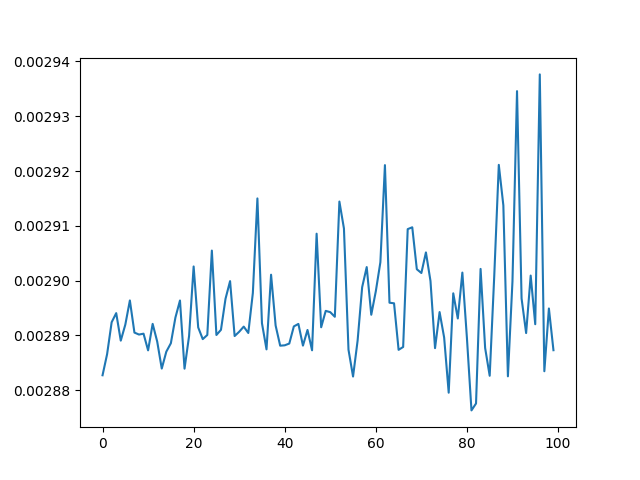

0.555444
0.554253


In [255]:
network_LSTM()

<IPython.core.display.Javascript object>


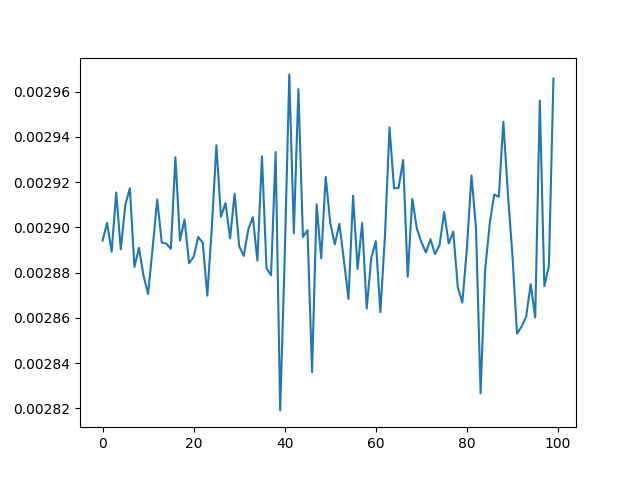

0.610944
0.610677


<IPython.core.display.Javascript object>


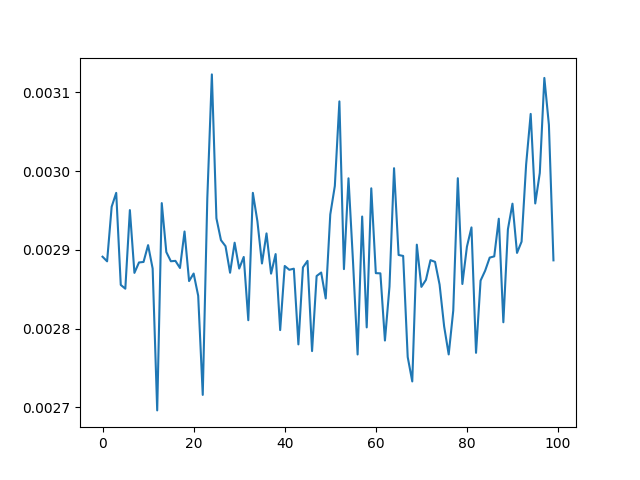

0.611056
0.609375


<IPython.core.display.Javascript object>


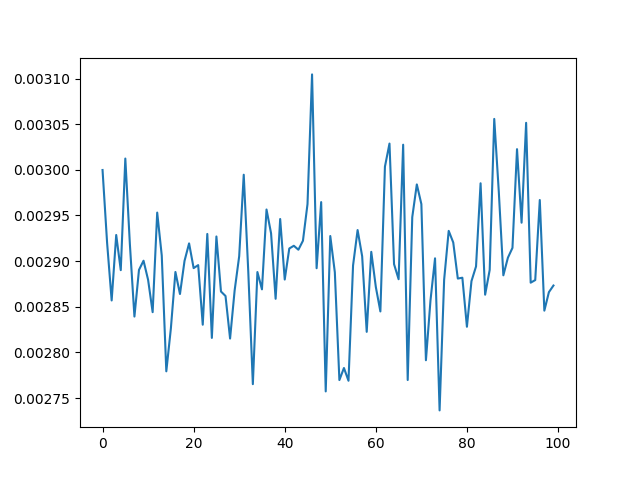

0.555444
0.555556


<IPython.core.display.Javascript object>


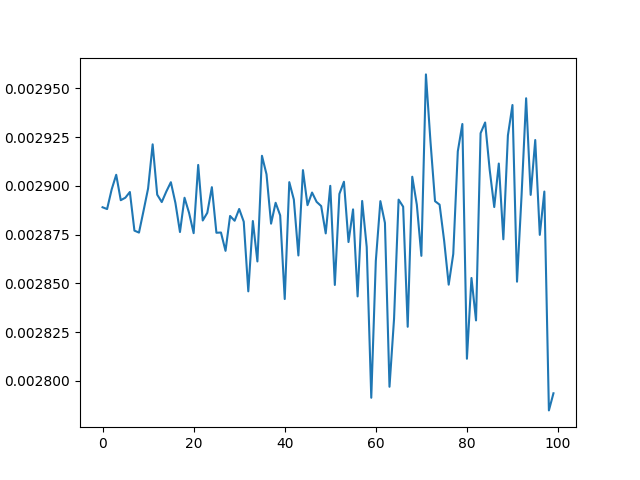

0.444444
0.444878


<IPython.core.display.Javascript object>


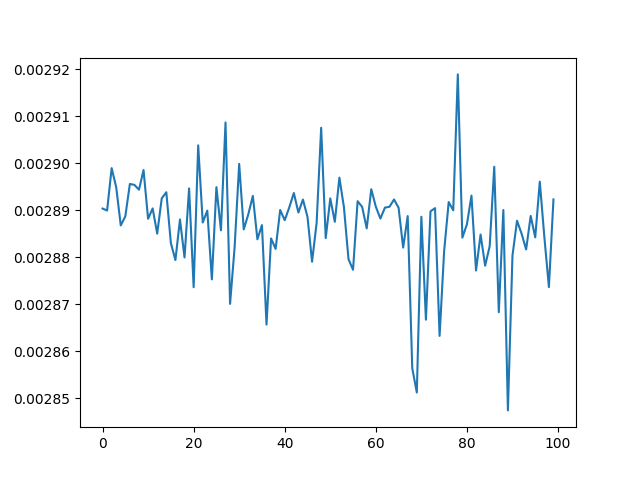

0.611111
0.611111


<IPython.core.display.Javascript object>


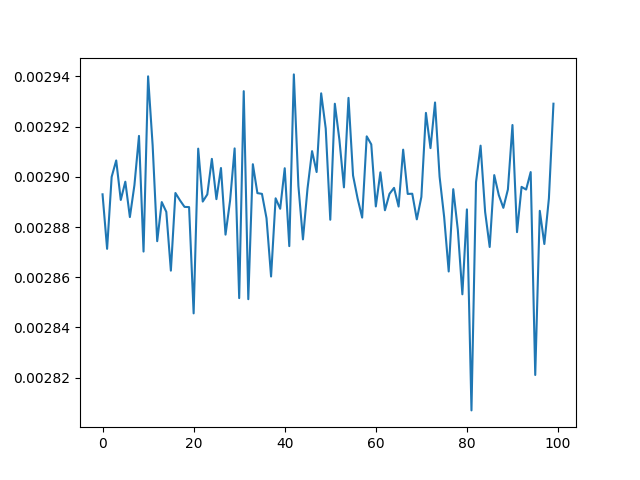

0.444556
0.44401


<IPython.core.display.Javascript object>


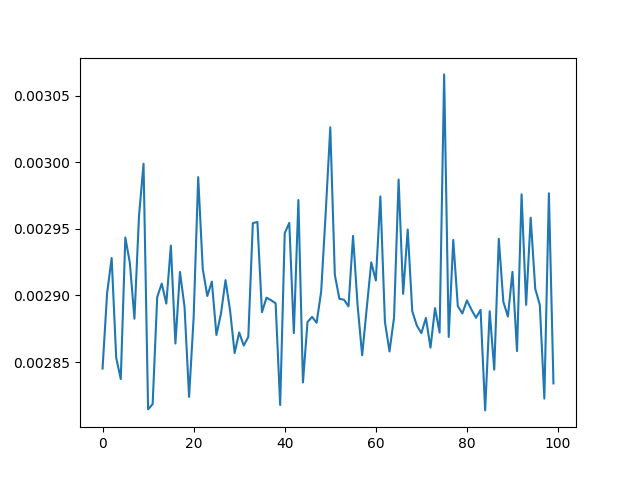

0.555333
0.554688


<IPython.core.display.Javascript object>


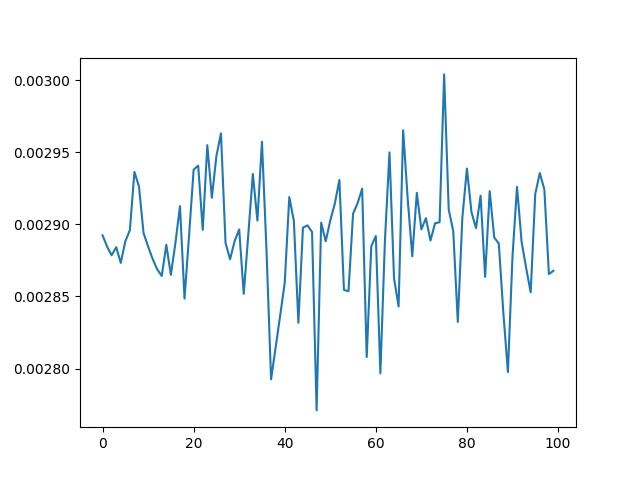

0.389167
0.388889


<IPython.core.display.Javascript object>


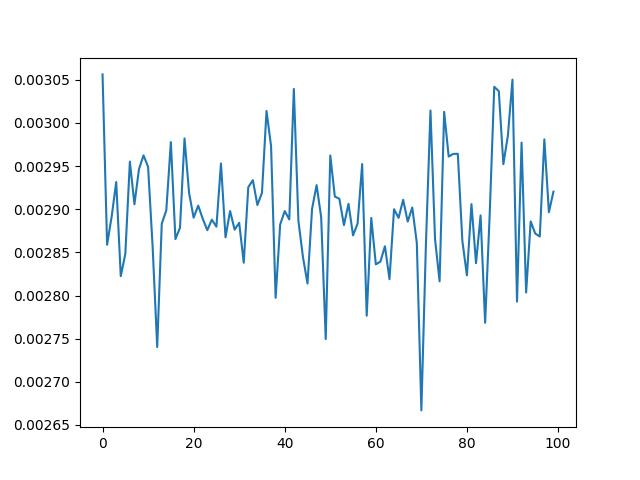

0.611
0.610677


<IPython.core.display.Javascript object>


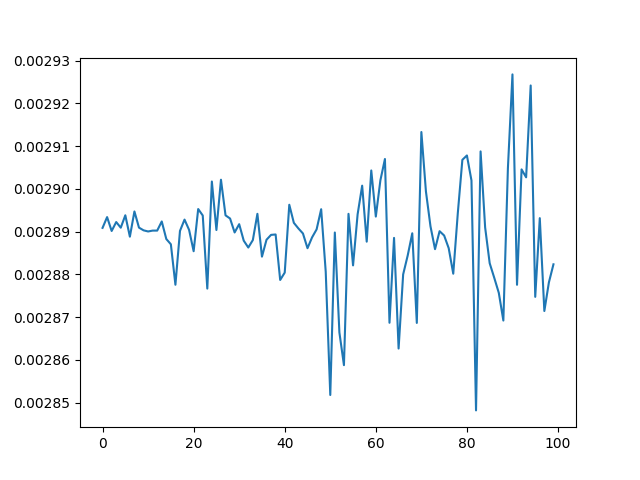

0.4445
0.444878
Accuracy on the training set is equal 0.5277555584907532, test set accuracy equals to 0.5274739861488342
Variance on the training set is equal 0.006926562637090683, test set variance equals to 0.006889363285154104


In [262]:

accuracy=[]
accuracy_test=[]
for i in range (10):
    a,a_test=network(i)
    accuracy.append(a)
    accuracy_test.append(a_test)
    

print("Accuracy on the training set is equal {}, test set accuracy equals to {}".format(np.mean(accuracy), np.mean(accuracy_test)))
print("Variance on the training set is equal {}, test set variance equals to {}".format(np.var(accuracy), np.var(accuracy_test)))
